In [52]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

# il faut integrer les volumes dans la data ce qu on donne c est uniquement des zeros 

In [53]:
from _on_balance_volume import OnBalanceVolume

In [54]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [55]:
data=pd.read_csv("MASI.csv",parse_dates=True, index_col=0)
data.Volume = data.Close

In [56]:
data.Volume

Date
2018-01-02    12420.15
2018-01-03    12509.58
2018-01-04    12463.08
2018-01-05    12537.75
2018-01-08    12479.42
                ...   
2022-03-28    12640.22
2022-03-29    12721.38
2022-03-30    12751.45
2022-03-31    12818.11
2022-04-01    12843.52
Name: Volume, Length: 1056, dtype: float64

In [57]:
obv = OnBalanceVolume(data)

In [58]:
df=data["close"].loc["2018-01-02":]
high=data["high"].loc["2018-01-02":]
low=data["low"].loc["2018-01-02":]


## Fonction

In [59]:
premier=0 

In [60]:
def GeneticAlgo(dim,obj_func,MAX_GENERATIONS,BOUND_LOW,BOUND_UP,POPULATION_SIZE=40,P_CROSSOVER = 0.9,P_MUTATION = 0.1):
	global premier
	ONE_MAX_LENGTH=dim
	HALL_OF_FAME_SIZE = 5
	CROWDING_FACTOR=20
	RANDOM_SEED = 40
	random.seed(RANDOM_SEED)
	if premier> 0 :
		del creator.FitnessMax
		del creator.Individual
	premier=premier+1
	toolbox = base.Toolbox()
	toolbox.register("Num", random.randint, BOUND_LOW, BOUND_UP)
	creator.create("FitnessMax", base.Fitness, weights=(1.0,))
	creator.create("Individual", list, fitness=creator.FitnessMax)
	toolbox.register("individualCreator", tools.initRepeat, creator.Individual, toolbox.Num, ONE_MAX_LENGTH)
	toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)
	toolbox.register("evaluate", obj_func)
	toolbox.register("select", tools.selTournament, tournsize=3)
	toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR)
	toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR, indpb=0.20)
	def main():
		population = toolbox.populationCreator(n=POPULATION_SIZE)
		stats = tools.Statistics(lambda ind: ind.fitness.values)
		stats.register("max", np.max)
		stats.register("avg", np.mean)
		hof = tools.HallOfFame(HALL_OF_FAME_SIZE)
		population, logbook = algorithms.eaSimple(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,ngen=MAX_GENERATIONS
			, stats=stats, halloffame=hof, verbose=True)
		print("Hall of Fame Individuals = ", *hof.items, sep="\n")
		print("Best Ever Individual = ", [ int(i) for i in hof.items[0]])
		maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")
		sns.set_style("whitegrid")
		plt.plot(maxFitnessValues, color='red')
		plt.plot(meanFitnessValues, color='green')
		plt.xlabel('Génération')
		plt.ylabel('Max / Moyenne Fitness')
		plt.title('Max et Moyenne de  Fitness opar générations')
		plt.show()
	main()

In [61]:
# Coût des transactions
ti=0.0022
fr=0.0011
cb=0.0011
taux=ti+fr+cb

In [62]:
def pmv(close,signal):
	"""
		La Plus-ou-moins-value
	"""
	close=np.array(close)
	signal=np.array(signal.fillna(0))
	qt=signal.cumsum()
	achat= np.where(signal>=1,1,0)
	PDR=[]
	for t in range(len(close)):
		p=(close[:t+1]*achat[:t+1]).sum()
		if achat[:t+1].sum()==0 :
			val=0
		else :
			p=p/(achat[:t+1].sum())
			val=qt[t]*p 
		PDR.append(val)
	PMV_lat=close*qt-PDR
	PMV_re=[0]
	for i in range(1,len(close)):
		vl=PDR[i]-PDR[i-1]+PMV_re[i-1]-close[i]*signal[i]
		PMV_re.append(vl)
	PMV=PMV_lat+PMV_re
	return PMV

In [63]:
def adjustsignal(signal):
	sig=[]
	qtite=0
	for i in signal:
		if i > 0 :
			sig.append(i)
			qtite+=1
		elif i < 0:
			if qtite >= abs(i) :
				sig.append(i)
				qtite+=-i
			else:
				sig.append(0)
		else:
			sig.append(0)
	return sig

## OBV

In [64]:
def obj_obv(n):
	n=int(n[0])
	signal=pd.DataFrame(index=df.index)
	ob=obv._calculateTi()["OBV"]
	obs=pd.Series(ob.rolling(n).mean(), name='obvsignal')
	signal["compa"]=np.nan 
	signal["compa"][n:]=np.where( ob[n:]  > obs[n:],1,0)
	signal["signal"]=adjustsignal(signal["compa"].diff())
	cours=df*(1+taux*signal["signal"])
	pmval=pmv(cours,signal["signal"])
	return pmval.max(),

C:\Users\T460s\anaconda3\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\T460s\anaconda3\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	max    	avg   
0  	40    	1516.26	349.74
1  	35    	1516.26	836.677
2  	38    	1516.26	1234.7 
3  	38    	1516.26	1464.1 
4  	40    	1516.26	1509.8 
5  	38    	1516.26	1496.89
6  	35    	1516.26	1468.19
Hall of Fame Individuals = 
[26.000137195447287]
[26.066010946315146]
[26.404974118833593]
[26.00711321061508]
[26]
Best Ever Individual =  [26]


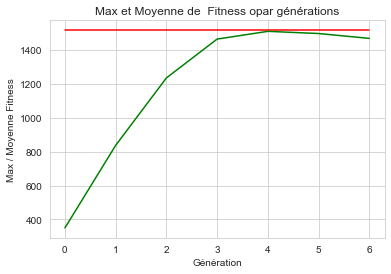

In [65]:
GeneticAlgo(1,obj_obv,6,10,100)